NameError: name 'det_jumps' is not defined

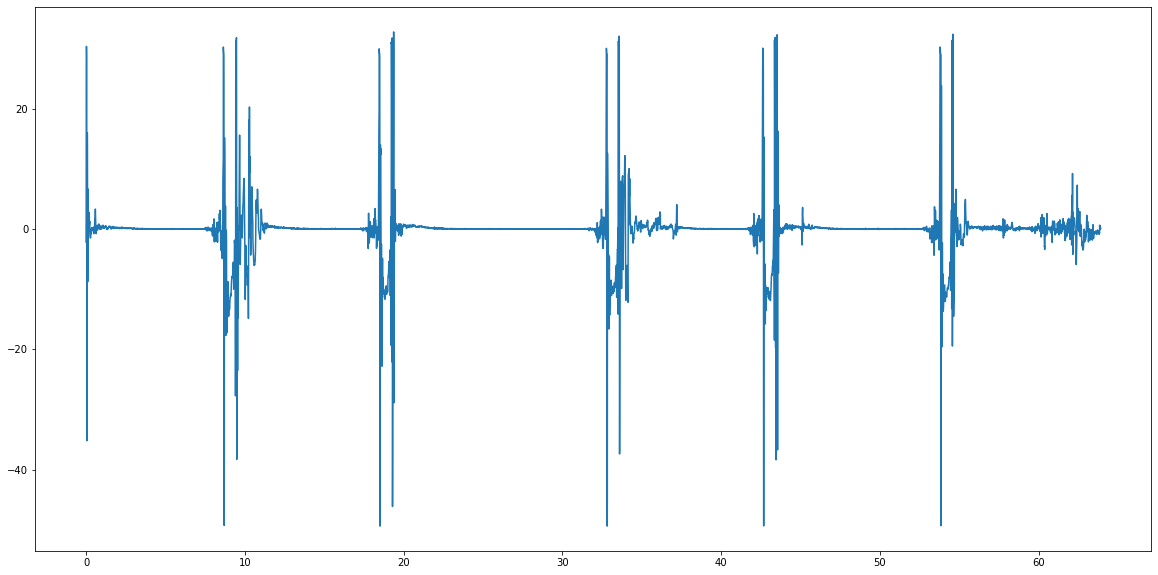

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import scipy as sp
import scipy.signal as sg
from scipy import fftpack as fft
from matplotlib import patches


fs = 202 #sampling frequency in Hz
df = pd.read_csv('CMJ X5.csv')
time = df['time']
time = time.subtract(time[0])
acc = df['ay (m/s^2)']

#Visually determined takeoff and landing times
true_jumps = [8.671, 9.378, 18.498, 19.189, 32.810, 33.483, 42.670, 43.323, 53.845, 54.511]

# #Determine syncronization point
# begin = int(52.5 * fs)
# end = int(55 * fs)
# plt.figure(figsize = (20,10))
# plt.plot(time[begin:end], acc[begin:end])
# plt.axhline(0)
# plt.axvline(54.18, color = 'r')
# #syncronize:  -54.18 seconds

time = time.subtract(54.2)
# time = time.subtract(54.18)

#zero at index 10970
t = time[10970:].reset_index(drop = True)
a = acc[10970:].reset_index(drop = True)

plt.figure(figsize = (20,10))
plt.plot(t,a)
for jump in det_jumps:
    plt.axvline(jump/fs, color = 'r')



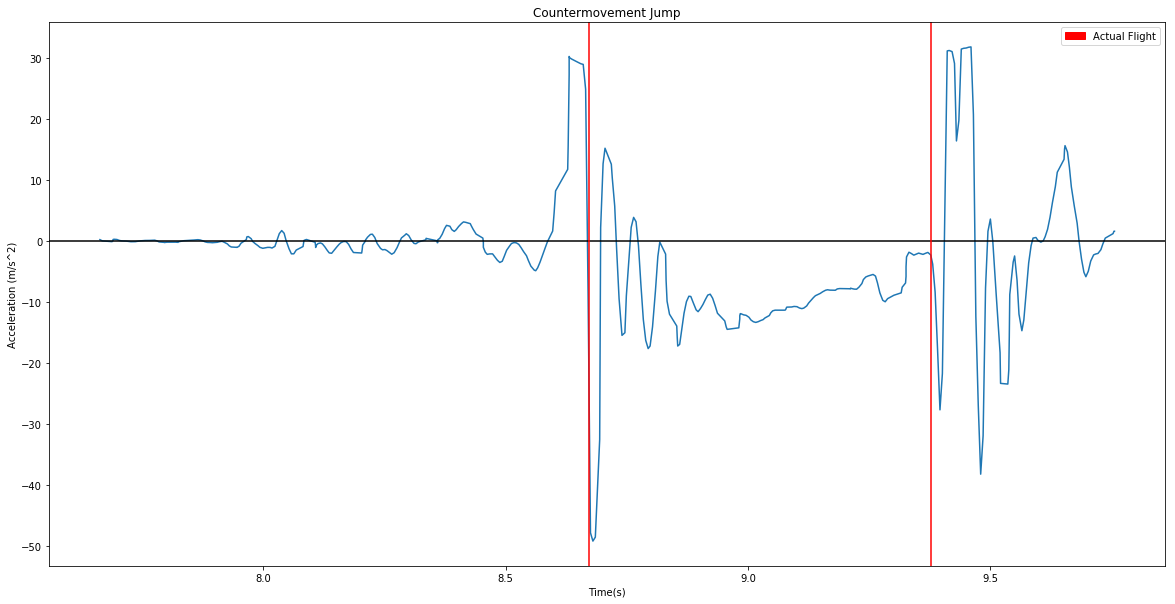

In [10]:
takeoff1 = 8.671 
land1 = 9.378 
j1a = int(takeoff1 * fs)
j1b = int(land1 * fs)
t1 = t[int(7.7*fs):int(9.8*fs)]
a1 = a[int(7.7*fs):int(9.8*fs)]

plt.figure(figsize = (20,10))
plt.plot(t1,a1)
plt.axhline(0, color = 'k')
plt.axvline(takeoff1, color = 'r')
plt.axvline(land1, color = 'r')
plt.title('Countermovement Jump')
plt.xlabel('Time(s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(handles =  [patches.Patch(color = 'r', label = 'Actual Flight')])


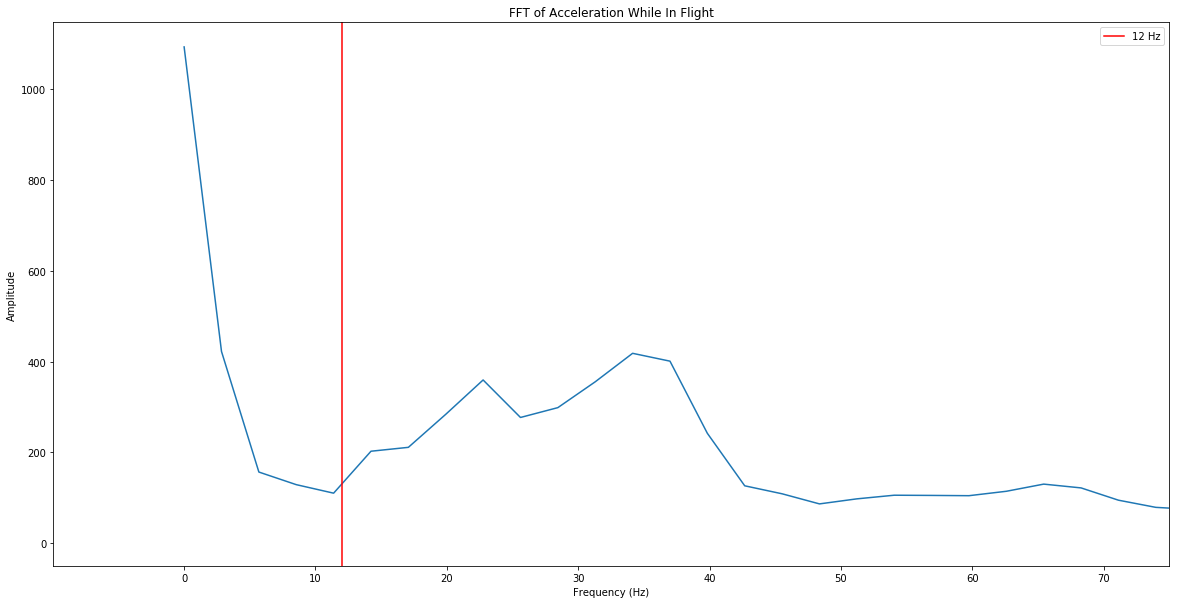

In [11]:
flight = a[1752:1894]

flightfft = fft.fft(flight)
freq = fft.fftfreq(flight.size, d= 1/(2*fs))

plt.figure(figsize = (20,10))
plt.plot(freq[0:int(len(freq)/2)], abs(flightfft[0:int(len(flightfft)/2)]))
plt.axvline(12, color = 'r', label = '12 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Acceleration While In Flight')
plt.xlim(right = 75)
plt.legend()

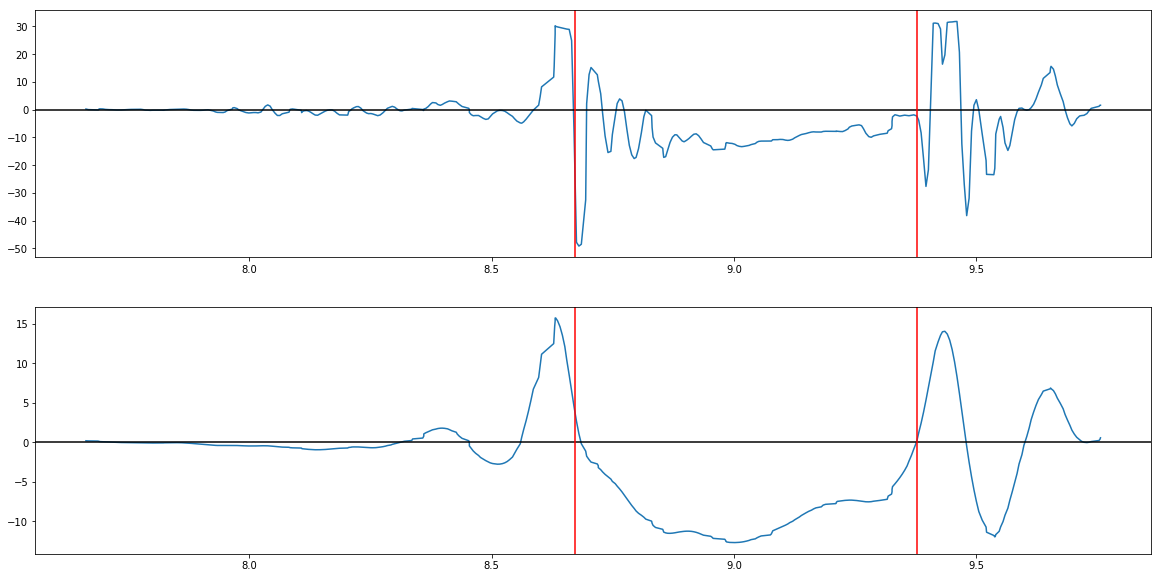

In [12]:
#Lowpass Filtering at 12Hz

wc = 12/fs #normalized cutoff frequency
bbutt, abutt = sg.butter(2, wc , btype = 'low') #Butterworth Lowpass Filter
a1flt = sg.filtfilt(bbutt, abutt, a1)

fig, axs = plt.subplots(2, figsize = (20,10))
axs[0].plot(t1,a1)


axs[1].plot(t1,a1flt)
# axs[1].axvline(8.71, color = 'r')

for i in range (len(axs)):
    axs[i].axhline(0, color = 'k')
    axs[i].axvline(8.671, color = 'r')
    axs[i].axvline(9.378, color = 'r')

# plt.figure(figsize=(20,10))
# plt.plot(t1,a1flt)
# plt.axhline(linestyle = '-', color = 'k')
# plt.axhline(-9.8,linestyle = ':', color = 'g')
# plt.title('Filtered Countermovement Jump Signal', fontsize = 10)
# plt.xlabel('Time(s)')
# plt.ylabel('Acceleration  (m/s^2)')
# txt = 'Fig. 1b. Vertical acceleration signal for a CMJ, filtered by a 4th order butterworth lowpass filter with cutoff frequency at 12 Hz '
# plt.figtext(0.5, 0.01, txt, wrap=True,horizontalalignment='center',  fontsize=10)



Estimation Algorithm


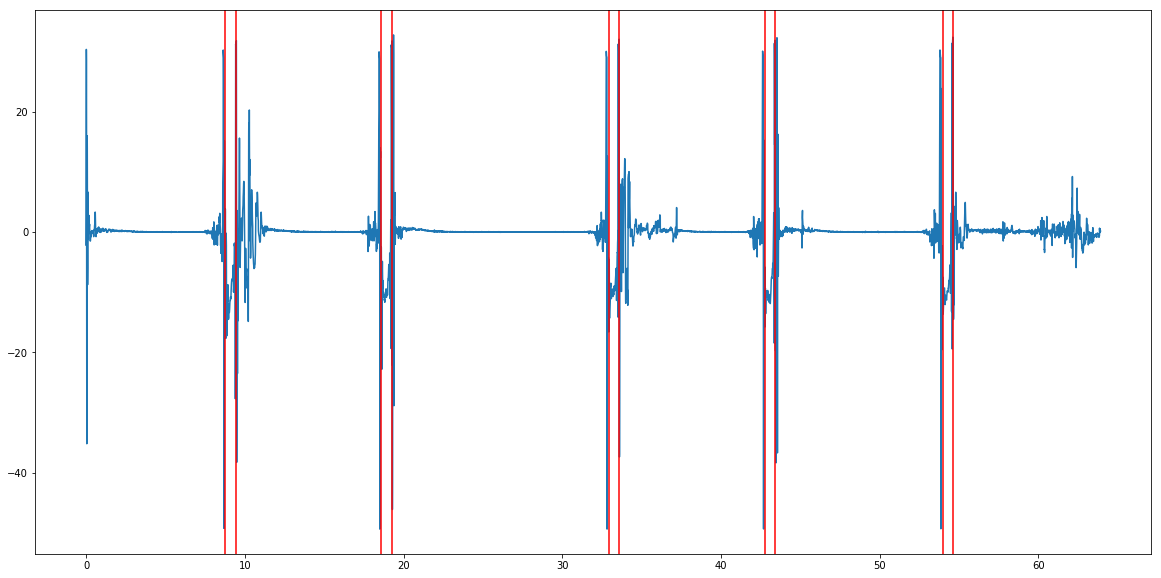

In [13]:
THRESHOLD = .5 #hangtime threshold to count as a detection, in seconds
GRAV = -9.81 #acceleration due to gravity
def jumps(accel): #determines takeoff and landing times. Returns array with times
    wc = 12/fs #normalized cutoff frequency
    bbutt, abutt = sg.butter(2, wc , btype = 'low') #Butterworth Lowpass Filter
    aflt = sg.filtfilt(bbutt, abutt, accel)
    flight = []
    n=0
    while n < len(aflt) - 1:
        takeoff = land = 0
        if aflt[n] >= 0 and aflt[n + 1] < 0:
            takeoff = n 
#             print(n)
            i = 1
            while land == 0:
                if aflt[n + i] > 0:
                    land = (n + i) 
                i += 1
            hangtime = land - takeoff
            if hangtime > THRESHOLD * fs:
                real_jump = False
                for x in aflt[int(takeoff):int(land)]:
                    if x < GRAV:
                        real_jump = True
                if real_jump == True:
                    flight.append(takeoff)
                    flight.append(land)
        n += 1
    return flight


det_jumps = jumps(a)
plt.figure(figsize = (20,10))
plt.plot(t,a)
for jump in det_jumps:
    plt.axvline(jump/fs, color = 'r')

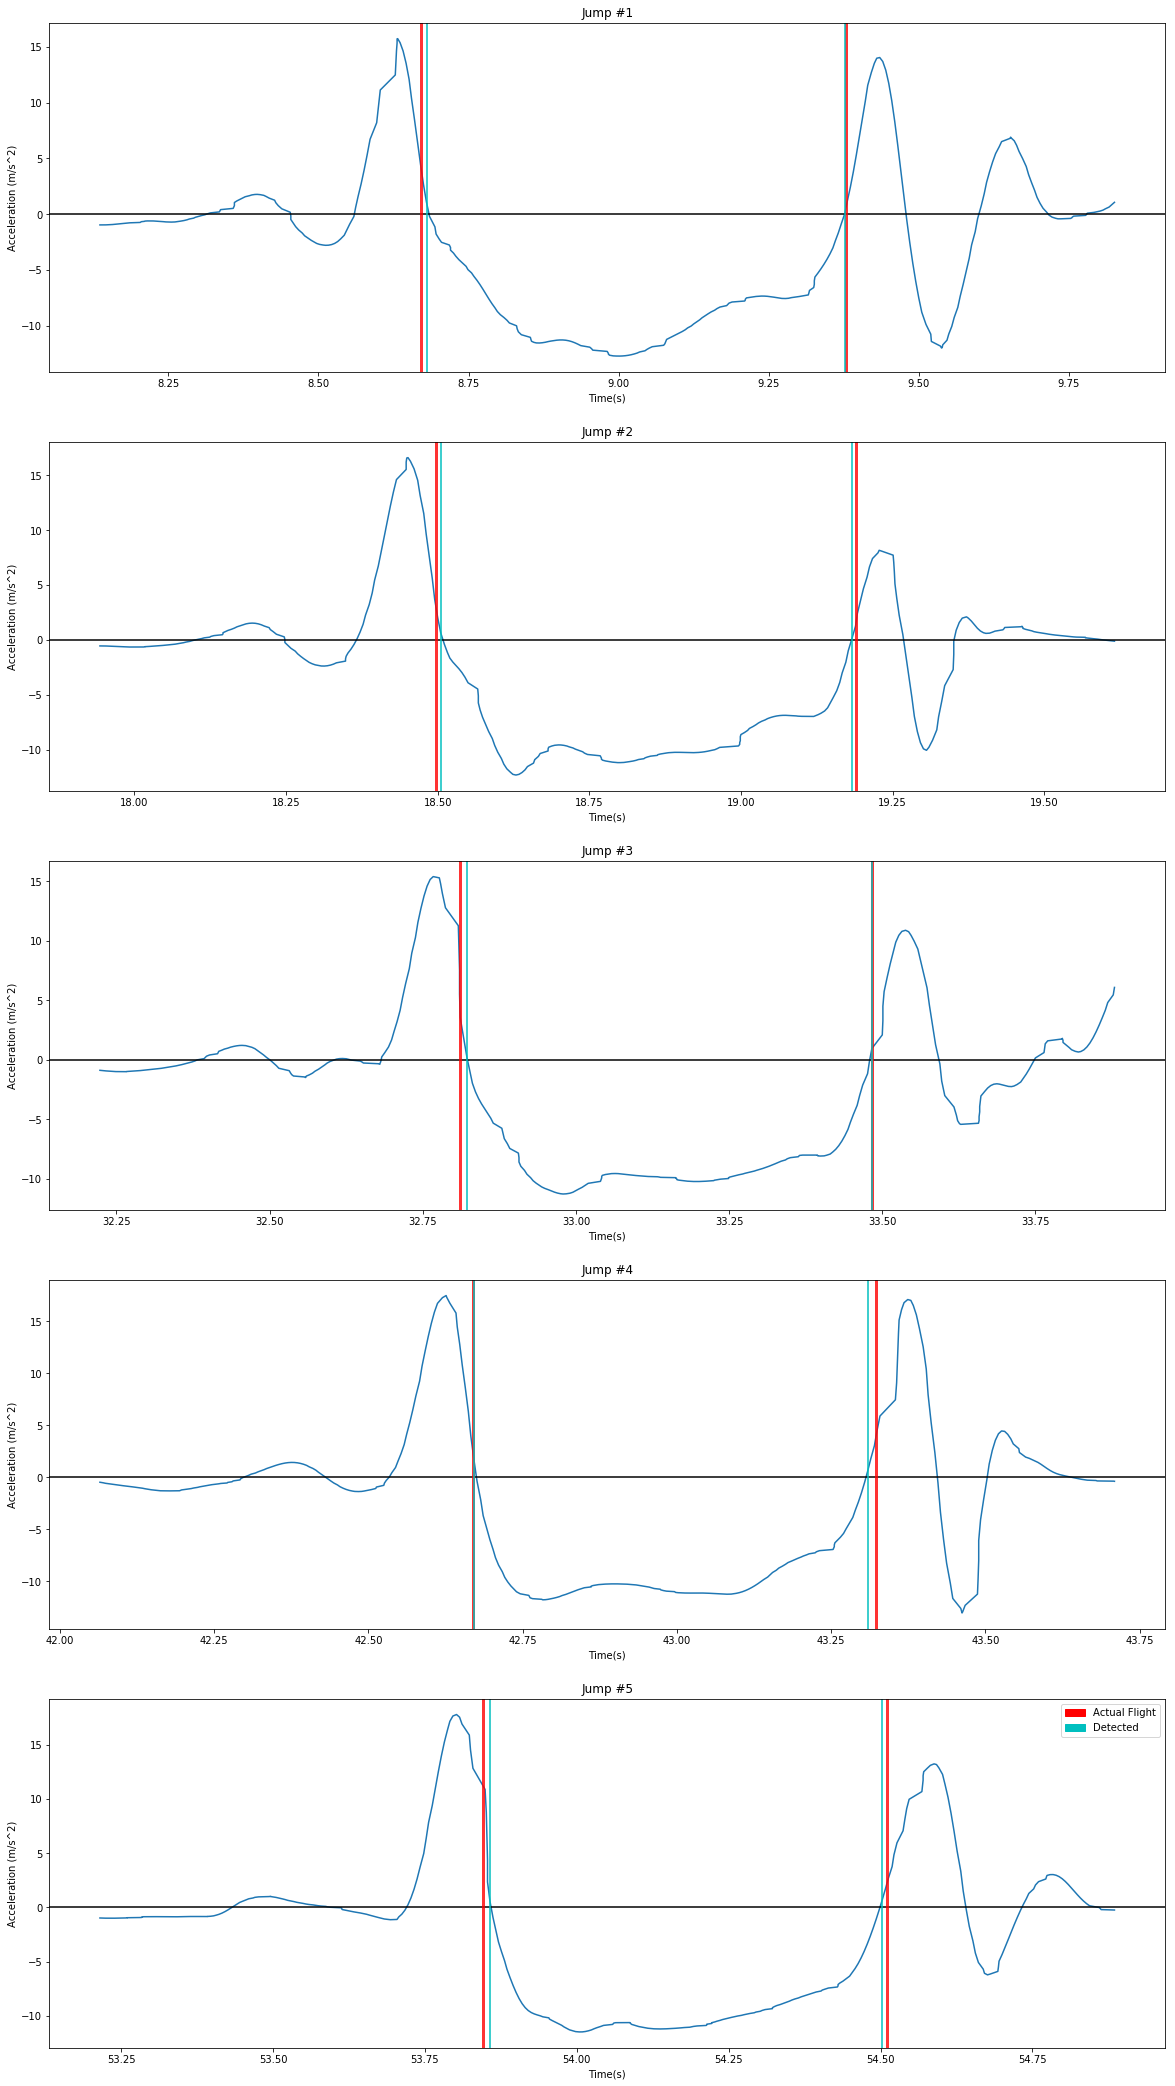

In [15]:
def plots(T, A, det, act):
    wc = 12/fs #normalized cutoff frequency
    bbutt, abutt = sg.butter(2, wc , btype = 'low') #Butterworth Lowpass Filter
    Aflt = sg.filtfilt(bbutt, abutt, A)
    
    fig, axs = plt.subplots(5, figsize = (20,15))
    fig.subplots_adjust(top = 2)
    plt.legend(handles =  [patches.Patch(color = 'r', label = 'Actual Flight'), patches.Patch(color = 'c', label = 'Detected')])
    i = 0
    j = 0
    while j < len(act)/2 :
        begin = int(act[i] * fs) - 100
        end = int(act[i + 1] * fs) + 100
        axs[j].plot(T[begin:end], Aflt[begin:end])
        axs[j].axhline(0, color = 'k')
        axs[j].axvline(act[i], color = 'r', label = 'Actual', linewidth = 3, alpha = .8)
        axs[j].axvline(act[i+1], color = 'r', label = 'Actual', linewidth = 3, alpha = .8)
        axs[j].axvline(T[det[i]], color = 'c')
        axs[j].axvline(T[det[i + 1]], color = 'c')
        
        axs[j].set_title('Jump #{}'.format(j + 1))
        axs[j].set_xlabel('Time(s)')
        axs[j].set_ylabel('Acceleration (m/s^2)')

        i += 2
        j += 1
        
        
plots(t, a, det_jumps, true_jumps)
# begin = int(true_jumps[2] * fs) - 100
# end = int(true_jumps[i + 1] * fs) + 100

# plt.plot(t[begin:end], a[begin:end])        

[8.717821782178218,
 9.415841584158416,
 18.564356435643564,
 19.242574257425744,
 32.91089108910891,
 33.57425742574257,
 42.78217821782178,
 43.42079207920792,
 53.99009900990099,
 54.63861386138614]

In [8]:
true_jumps

[8.671, 9.378, 18.498, 19.189, 32.81, 33.483, 42.67, 43.323, 53.845, 54.511]

In [9]:
#FFT of First jump

# a1fft = fft.fft(a1)
# freq = fft.fftfreq(a1.size, d= 1/(2*fs))

# plt.figure(figsize = (20,10))
# plt.plot(freq[0:int(len(freq)/2)], abs(a1fft[0:int(len(a1fft)/2)]))
# plt.axvline(12, color = 'r')

In [10]:
# # time = time.subtract(time[0]) #adjusts time for when sample collection begins
# time = time.subtract(58.18) #Syncronize with video using 3rd foot stomp as reference

# #syncronized time and acceleration data
# t = time[10833:].reset_index(drop = True)
# a = acc[10833:].reset_index(drop = True)


# takeoff1 = 8.671 
# land1 = 9.378 
# j1a = int(takeoff1 * fs)
# j1b = int(land1 * fs)
# t1 = t[int(8.5*fs):int(9.5*fs)]
# a1 = a[int(8.5*fs):int(9.5*fs)]


In [11]:
# plt.figure(figsize = (20,10))
# plt.plot(t1,a1)
# plt.axhline(0, color = 'k')

In [23]:
# plt.figure(figsize = (20,10))
# plt.plot(t,a)
# plt.axhline(0, color = 'k')
flight = []
n = 0
while n < len(a1flt) - 1:
    takeoff = land = 0
    if a1flt[n] >= 0 and a1flt[n + 1] < 0:
        takeoff = n 
#             print(n)
        i = 1
        while land == 0:
            if a1flt[n + i] > 0:
                land = (n + i) 
            i += 1
        hangtime = land - takeoff
        if hangtime > THRESHOLD * fs:
            real_jump = False
            for x in a1flt[int(takeoff):int(land)]:
                if x < GRAV:
                    real_jump = True
            if real_jump == True:
                flight.append(takeoff)
                flight.append(land)# plt.axvline(54.18, color = 'k')
    n += 1
flight


[206, 347]

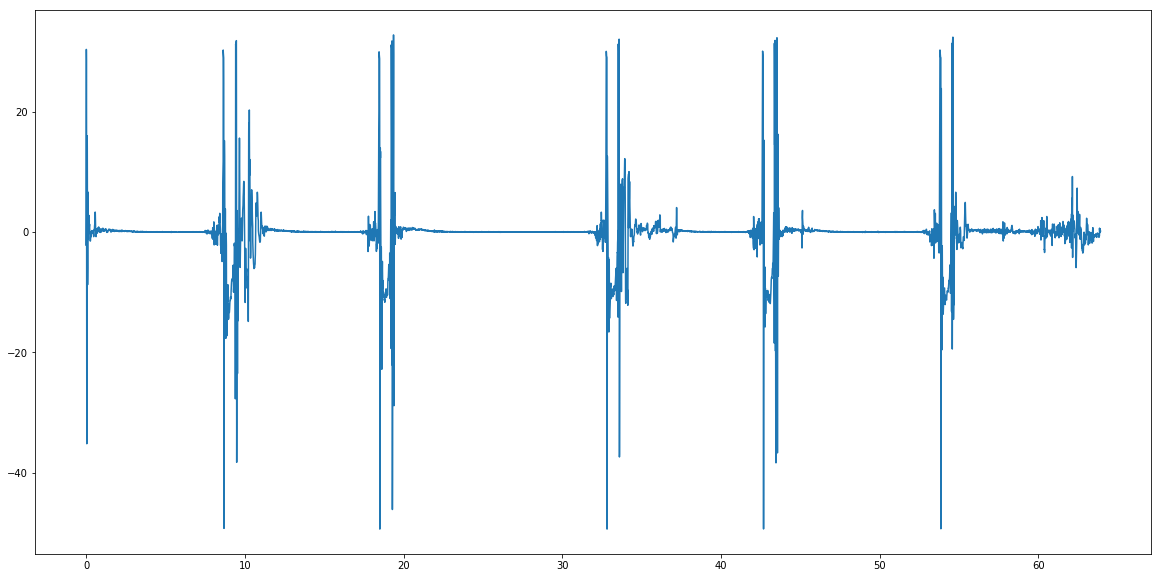

In [59]:
plt.figure(figsize = (20,10))
plt.plot(t,a)

In [71]:
def stats(act, det):
    det_s = np.divide(det, fs)
    bias = np.mean(np.subtract(det_s, act))
    RMSE = (bias ** 2) ** 1/2
    print(bias)
    print(RMSE)
stats(true_jumps, det_jumps)        

0.08794257425742487
0.0038669481835113435


In [80]:
def flight_times(jumps):
    flight_time = []
    i = 0
    while i < len(jumps):
        hangtime = jumps[i+1] - jumps[i]
        flight_time.append(hangtime)
        i += 2
    return flight_time

det_hangtime = flight_times(np.divide(det_jumps, fs))
true_hangtime = flight_times(true_jumps)

det_hangtime

[0.6980198019801982,
 0.6782178217821802,
 0.6633663366336648,
 0.6386138613861405,
 0.6485148514851531]

In [81]:
true_hangtime

[0.7070000000000007,
 0.690999999999999,
 0.6729999999999947,
 0.6529999999999987,
 0.6660000000000039]

In [77]:
det_jumps

[1761, 1902, 3750, 3887, 6648, 6782, 8642, 8771, 10906, 11037]

In [78]:
np.divide(true_jumps, fs)

array([0.04292574, 0.04642574, 0.09157426, 0.09499505, 0.16242574,
       0.16575743, 0.21123762, 0.2144703 , 0.26655941, 0.26985644])